<a href="https://colab.research.google.com/github/hmelberg/health-analytics-using-python/blob/dev/2_Ways_of_counting_How_many_and_how_often%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. Ways of counting: How many and how often?




## Background
When analyzing health data we ofte have a dataset where each person can have many events like prescriptions or hospital visits. Event based data is well suited to answer event level questions like:
* How many hospital stays are related to pneumonia? 
* How often is a certain pharmaceutical prescribed?

However, often we also want to use the event level data to answer individual level questions. For instance: 
* How many different patients have been admitted to hospital for inflammatory bowel disease? 
* How many individuals with a given disease have received a prescription for steroids? 

Answering individual level questions using event level data is sometimes easy, but quite often it requires careful thought and several lines of coding. In this chapter we will show you examples of how it can be done in Pyton and Pandas. 

The starting point is an example where we count the number of hospital events and unique persons related to a medical code - pneumonia - that is located in a single column in the dataframe. We then treat more complicated cases, with multiple columns and multiple codes. Towards the end we will merge the different cases and create a new method that make it easier to use event level data to answer individual level questions.


## Example: Pneumonia




###Import libraries

In [0]:
import pandas as pd

### Get data

We will use data from Medicare. It is a sample of data that is artificial, but with some features that makes it look like the actual data they have of hospital events between 2008 and 2010.

For more information about the data, see [The Centers for Medicare & Medicaid Services](https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/DE_Syn_PUF).


In [0]:
# Read synthetic medicare sample data on inpatient hospital stays
path = 'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/'
inpatient_file = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.zip'
inpatient = pd.read_csv(path+inpatient_file)

### First look


In [0]:
inpatient.head()

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_ADMSN_DT,ADMTNG_ICD9_DGNS_CD,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6,HCPCS_CD_1,HCPCS_CD_2,HCPCS_CD_3,HCPCS_CD_4,...,HCPCS_CD_6,HCPCS_CD_7,HCPCS_CD_8,HCPCS_CD_9,HCPCS_CD_10,HCPCS_CD_11,HCPCS_CD_12,HCPCS_CD_13,HCPCS_CD_14,HCPCS_CD_15,HCPCS_CD_16,HCPCS_CD_17,HCPCS_CD_18,HCPCS_CD_19,HCPCS_CD_20,HCPCS_CD_21,HCPCS_CD_22,HCPCS_CD_23,HCPCS_CD_24,HCPCS_CD_25,HCPCS_CD_26,HCPCS_CD_27,HCPCS_CD_28,HCPCS_CD_29,HCPCS_CD_30,HCPCS_CD_31,HCPCS_CD_32,HCPCS_CD_33,HCPCS_CD_34,HCPCS_CD_35,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
0,00013D2EFD8E45D1,196661176988405,1,20100312.0,20100313.0,2600GD,4000.0,0.0,3.139084e+09,NaN,NaN,20100312,4580,0.0,1100.0,0.0,0.0,1.0,20100313,217,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00016F745862898F,196201177000368,1,20090412.0,20090418.0,3900MB,26000.0,0.0,6.476809e+09,NaN,NaN,20090412,7866,0.0,1068.0,0.0,0.0,6.0,20090418,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00016F745862898F,196661177015632,1,20090831.0,20090902.0,3900HM,5000.0,0.0,6.119985e+08,6.119985e+08,NaN,20090831,6186,0.0,1068.0,0.0,0.0,2.0,20090902,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,6186,V5866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00016F745862898F,196091176981058,1,20090917.0,20090920.0,3913XU,5000.0,0.0,4.971603e+09,NaN,1.119000e+09,20090917,29590,0.0,1068.0,0.0,0.0,3.0,20090920,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00016F745862898F,196261176983265,1,20100626.0,20100701.0,3900MB,16000.0,0.0,6.408400e+09,1.960860e+09,NaN,20100626,5849,0.0,1100.0,0.0,0.0,5.0,20100701,983,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN,NaN,E8889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Each row in the data represents an inpatient hospital event for a person. Each person can have multiple events and we have a dataframe with the persons' unique id (*desynpuf_id*), and many other columns such as:
* the date of the claim (*clm_from_dt*)
* the claim's DRG code (*clm_drg_cd*)* the diagnostic codes used (*icd9_dgns_cd_1* etc.)
* precdure codes (*icd9_prcdr_cd_1* etc).

For more information about the definition of the variables, see [ResDAC](https://www.resdac.org/cms-data/files/ip-encounter-final/data-documentation)


In [0]:
#Overview of variables (column names)
inpatient.columns

Index(['DESYNPUF_ID', 'CLM_ID', 'SEGMENT', 'CLM_FROM_DT', 'CLM_THRU_DT',
       'PRVDR_NUM', 'CLM_PMT_AMT', 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'OT_PHYSN_NPI', 'CLM_ADMSN_DT', 'ADMTNG_ICD9_DGNS_CD',
       'CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM',
       'CLM_UTLZTN_DAY_CNT', 'NCH_BENE_DSCHRG_DT', 'CLM_DRG_CD',
       'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
       'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
       'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
       'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
       'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'HCPCS_CD_1', 'HCPCS_CD_2',
       'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6', 'HCPCS_CD_7',
       'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11', 'HCPCS_CD_12',
       'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15', 

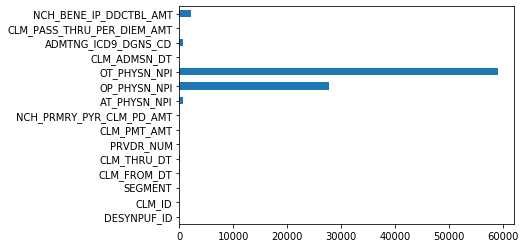

In [0]:
# Number of missing valules in different columns
inpatient.isnull().sum().head(15).plot.barh();

### Initial cleaning
* At first sight it may be tempting to change column names to something more intuitive, but it is probably better to keep it as it is because we will need to use the precise name when we want more information about how it is defined. 

* One might, instead, add some columns with names that are easier to use. For instance, instead of using *desynpuf_id* as the personal identifier, one might use a new column labelled *pid*.

* Upper case columns names are often cumbersome to type and one might want to change it all to lower case.

* It is very often useful to have the personal id as the index column since this will make it easier to merge the dataframe with other dataframes or series that have more information about the patients. However, the name of the index column should not conflict with a column name, so we set the index column to be *pid*, keep the original pid column, and label the index column *pid_index.*

* There are many other issues that should be checked and changed before analysis, such as datatype definitions and validation, but this is the topic of a separate chapter. For now, we press on with the main concern: How to use these data to answer questions about the frequency of events and the number of people who have been registered with specific diseases.

In [0]:
# Initial data preparation

inpatient.columns=inpatient.columns.str.lower()
inpatient['pid']=inpatient.desynpuf_id
inpatient=inpatient.set_index('pid', drop=False)
inpatient.index.name='pid_index'

##How many pneumonia events and patients?

In the ICD 9 coding system, the code for 'Pneumonia' with unspecified origin is *486*. We also know that the admitting ICD 9 diagnosis recorded for a patient is in the column *admtng_icd9_dgns*. This means that to find the number of pneumonia events, we may start with the *inpatient* dataframe, select the *admtng_icd9_dgns_cd* column, check if the rows are equal to 486, and sum the number of times this is true. In code, which reads almost like the verbal description, we have:



In [0]:
# Number of pneumonia events as the admitting diagnosis code

(inpatient.admtng_icd9_dgns_cd == '486').sum()


2363

Since the same patient may get pneumonia several times, the number of events will not be the same as the number of people who have had pneumonia. To find the number of persons, we can use a two step approach. First we identify the rows with a pneumonia diagnosis. We then select the relevant rows and count how many unique persons there are using the *nunique()* method in Pandas: 

### Identify relevant rows and count unique person ids using *nunique()*

In [0]:
pneumonia_rows=(inpatient.admtng_icd9_dgns_cd == '486')

inpatient[pneumonia_rows].pid.nunique()

2290

Above we used a two step approach where we first selected the relevant rows, and then used this to find the number of patients with pneumonia. We could have done this all in one single operation:



In [0]:
# Number of patients who have had a pneumonia event

inpatient[inpatient.admtng_icd9_dgns_cd == '486'].pid.nunique()

# Or, the same as above, but using the query method to select the relevant rows

inpatient.query("admtng_icd9_dgns_cd=='486'").pid.nunique()


2290

The long chain is not too bad in this case, but in general it is better to  break the analysis down into small and readable steps since this makes it easier to discover mistakes in the analysis. In this sense, 

```inpatient[pneumonia_rows].pid.nunique()```

is better than 

```inpatient[inpatient.admtng_icd9_dgns_cd == '486'].pid.nunique()```

Not only is it more readable, is is also reusable. We have created an object, *pneumonia_rows*, that can be used later on when we want to select these rows, without having to write the code and the conditions once again. For instance, if we want to find out how many pneumonia events there were in 2010:





In [0]:
# mark rows with claims from dates in 2010
year_2010_rows = inpatient.clm_from_dt.astype(str).str.startswith('2010')

# how many events have pneumonia codes as the admission diagnosis and are in 2010
(pneumonia_rows & year_2010_rows).sum()

413

In this code we reused the object called *pneumonia_rows*. The code also shows some of the simpliclity and power of the notation of python and pandas. A simple symbol - & - between two objects will automatically produce a new object that is true for those rows where both objects are true ie. the row is from 2010 and it has a pneumonia dianosis.

Note (Gotcha): If you change the length or the row-order (sorting) of the dataframe, the *pneumonia_rows* object should be recalculated.

## Potential problem: Multiple code columns

The method outlined above works well when we are counting a single code that exists in a single column. Often, however, we have many columns with diagnostic codes (icd_1, icd_2 etc). Pandas can handle this quite easily by first selecting the relevant columns and then asking which of the cells that contain the code we are interested in. 

Make a list of relevant columns

In [0]:
icd_columns = ['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4',
       'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8',
       'icd9_dgns_cd_9', 'icd9_dgns_cd_10']

Select the columns from the dataframe

In [0]:
inpatient[icd_columns] 

,icd9_dgns_cd_1,icd9_dgns_cd_2,icd9_dgns_cd_3,icd9_dgns_cd_4,icd9_dgns_cd_5,icd9_dgns_cd_6,icd9_dgns_cd_7,icd9_dgns_cd_8,icd9_dgns_cd_9,icd9_dgns_cd_10
pid_index,,,,,,,,,,
00013D2EFD8E45D1,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN
00016F745862898F,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN
00016F745862898F,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00016F745862898F,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN
00016F745862898F,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN
...,...,...,...,...,...,...,...,...,...,...
FFF8B49458F9FFA7,4871,41400,27651,60000,40390,3659,NaN,NaN,NaN,NaN
FFF8B49458F9FFA7,9694,2989,9663,58881,2859,5790,NaN,NaN,NaN,NaN
FFFA950301FCA748,1985,3694,25000,73300,33829,4168,2859,28522,NaN,NaN


Mark the cells that are equal to code 486

In [0]:
inpatient[icd_columns] == '486'

,icd9_dgns_cd_1,icd9_dgns_cd_2,icd9_dgns_cd_3,icd9_dgns_cd_4,icd9_dgns_cd_5,icd9_dgns_cd_6,icd9_dgns_cd_7,icd9_dgns_cd_8,icd9_dgns_cd_9,icd9_dgns_cd_10
pid_index,,,,,,,,,,
00013D2EFD8E45D1,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
FFF8B49458F9FFA7,False,False,False,False,False,False,False,False,False,False
FFF8B49458F9FFA7,False,False,False,False,False,False,False,False,False,False
FFFA950301FCA748,False,False,False,False,False,False,False,False,False,False


In [0]:
# Sum all the values in the dataframe
(inpatient[icd_columns] == '486').values.sum()

6064

Notice that we this time get more events since we counted not only the single admission diagnostic code, but all (ten) possible diagnostic codes that were used to describe the event. Pneumonia could be a secondary or third diagnosis and this last counting includes these codes as well.

The approach of creating a new dataframe with cells that are true or false depending on a condition, is a powerful idea that can be used when we only want to include some cells in a calculation. You will often see this referred to as a 'mask.' ie:



In [0]:
mask= inpatient[icd_columns] == '486'
mask.values.sum()


6064

Note also that it is possible to select the relevant columns using *.loc()* and so-called fancy-indexing:

In [0]:
# use loc to select relevant colums. 
inpatient.loc[:,'icd9_dgns_cd_1':'icd9_dgns_cd_10']

,icd9_dgns_cd_1,icd9_dgns_cd_2,icd9_dgns_cd_3,icd9_dgns_cd_4,icd9_dgns_cd_5,icd9_dgns_cd_6,icd9_dgns_cd_7,icd9_dgns_cd_8,icd9_dgns_cd_9,icd9_dgns_cd_10
pid_index,,,,,,,,,,
00013D2EFD8E45D1,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN
00016F745862898F,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN
00016F745862898F,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00016F745862898F,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN
00016F745862898F,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN
...,...,...,...,...,...,...,...,...,...,...
FFF8B49458F9FFA7,4871,41400,27651,60000,40390,3659,NaN,NaN,NaN,NaN
FFF8B49458F9FFA7,9694,2989,9663,58881,2859,5790,NaN,NaN,NaN,NaN
FFFA950301FCA748,1985,3694,25000,73300,33829,4168,2859,28522,NaN,NaN


The format for the *.loc()* method is: 

```loc[row selection, column selection]```

The fancy notation for selection means that it is possible to use several efficient shortcuts. For instance, consider again:

```inpatient.loc[:,'icd9_dgns_cd_1':'icd9_dgns_cd_10']```

The row selector is just a colon (:) which is shorthand for "select every row" while the colum selector ```'icd9_dgns_cd_1':'icd9_dgns_cd_10'``` means "use every column between (and including) *icd9_dgns_cd_1* and *icd9_dgns_cd_10*.

In this way we do not have to specify the full list of columns. This is very useful for quick explorations, but it also makes the analysis dependent on the order of the columns. In this sense it is less robust than the explicit approach of naming all the relevant columns. For productions and publication analysis one should consider the more explicit approach.

###A side note on the *.loc()* notation

```(inpatient[icd_columns] == '486').values.sum()```

does the same as:

```(inpatient.loc[:,icd_columns] == '486').values.sum()```

One difference, and an advantage of using *loc()*, is that it is posssible to combine both row and column selection. For instance, if we want to count the number of pneumonia events in 2010:

In [0]:
# Using *.loc()* to select on rows as well as columns
(inpatient.loc[year_2010_rows,icd_columns] == '486').values.sum()

1166

Once again, we get more events this time because we use all ten diagnoses and not only the main diagnosis.


Lastly, *.loc()* should be used when you want to assign values as opposed to just viewing or counting. Despite its slightly more complicated structure, many recommend that *.loc()* always be used to select from dataframes.

## Counting persons with mutiple relevant columns

Having counted the number of *events* of a given code acrosss several columns, the next question is how many *individuals*  who have a pneumonia code in any of the specified columns. To answer this we use Pandas *.any()* method which returns True or False if any of the values in a row (axis=1), or a column (axis=0), or for unique values in the index (level=1) are True.

To find the total number of patients admitted with pneumonia, unspecified organism (code 486) across all diagnoses we start by creating a mask, like we did when counting events:

In [0]:
# Create a mask that mark cells with the code 486
mask = inpatient[icd_columns] == '486'
mask.head()

,icd9_dgns_cd_1,icd9_dgns_cd_2,icd9_dgns_cd_3,icd9_dgns_cd_4,icd9_dgns_cd_5,icd9_dgns_cd_6,icd9_dgns_cd_7,icd9_dgns_cd_8,icd9_dgns_cd_9,icd9_dgns_cd_10
pid_index,,,,,,,,,,
00013D2EFD8E45D1,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False


We then ask if any of the row values are True i.e. if there is a pneumonia diagnois in any of the ICD columns for that row:

In [0]:
pneumonia_rows = mask.any(axis=1)
pneumonia_rows

pid_index
00013D2EFD8E45D1    False
00016F745862898F    False
00016F745862898F    False
00016F745862898F    False
00016F745862898F    False
                    ...  
FFF8B49458F9FFA7    False
FFF8B49458F9FFA7    False
FFFA950301FCA748    False
FFFC880E13CA6278    False
FFFE3ED9582AD46E    False
Length: 66773, dtype: bool

Once we have the rows, we can count the number of unique persons (pids) that exist in the dataframe with the relevant rows. This will be the number of people with pneumonia:

In [0]:
inpatient[pneumonia_rows].pid.nunique()

5509

It may be instructive to contrast this with another approach. Instead of counting personal ids, we could use the *level=1* argument in *any()* to see if persons with the same id has any True observations. True here means "have received a pneumonia diagnosis". Like this:

In [0]:
# Ask if any of the observations for the same pid (in the index) are True (i.e. if the person has ever received code 486)
pneumonia_rows.any(level=0) 

pid_index
00013D2EFD8E45D1    False
00016F745862898F    False
00052705243EA128     True
0007F12A492FD25D    False
000B97BA2314E971    False
                    ...  
FFF5F9218AB04A41    False
FFF8B49458F9FFA7    False
FFFA950301FCA748    False
FFFC880E13CA6278    False
FFFE3ED9582AD46E    False
Length: 37780, dtype: bool

Note that this approach depends on the fact that the individual id is in the index.

Finally, we sum the number of individuals who have a pneumonia diagnosis in any of the rows to get the same answer as previously:


In [0]:
# Sum the number of people who have received a pneumonia code
pneumonia_rows.any(level=0).sum()

5509

These methods are so powerful that it is useful to summarize:
* *.any(axis=0)* : For each row it returns true if any of the values in the rows are true
* *.any(axis=1)* : For each column it returns true if any of the values in the column is true
* *.any(level=0)* : For each unique value in the index it returns true if any of the observations with the same index value is true.

All of this, in one long chain is:


In [0]:
# All in one chain
(inpatient.loc[:,icd_columns] == '486').any(axis=1).any(level=0).sum()

5509

Once again it may be easy to understand the long chain if you are used to the Pandas API, but giving thing names and breaking it up is usually a good idea.

For instance, the use of *any()* twice in a row may sometimes confuse people. Similarly the meaning of the argument "*level=1* may not be obvious. All in all, it seems that the most flexible and readable approach is to first name all rows that have a pneumonia code and then use this to count the unique persons.

The preferred approach is also more explicit in its focus on counting persons sice it uses a reference to pid. 

Altogether, it reads more like a sentence: Take the inpatient dataframe, select the rows with pneummonia, focus on the pids and count how many of them that are unique.

In [0]:
%%timeit
inpatient[pneumonia_rows].pid.nunique()

100 loops, best of 3: 12.6 ms per loop


which looks better than the more complex:

In [0]:

inpatient[inpatient.loc[:,icd_columns] == '486'].any(axis=1).any(level=0).sum() 

5509

And it is also more intuitive and explicit than:

In [0]:
pneumonia_rows.any(level=0).sum()

100 loops, best of 3: 9.84 ms per loop


which does not have an explicit reference to counting personal id's. 

 In short, to count the number of people with a diagnosis across several columns with diagnostic codes, we should first select the relecant rows, then focus on counting the unique pids in these rows:

In [0]:
pneumonia_rows = (inpatient[icd_columns] == '486').any(axis=1)
inpatient[pneumonia_rows].pid.nunique()

# What if you also have multiple codes?

So far we have counted the number of events and persons using only one code. This works if we want to count only one specific type of pneomonia, but what if there are many many medical codes that are relevant to pneumonia and you want to include them all? 

The general question is how we can count the number of cases when these cases are defined by multiple codes - and they are recorded in in multiple columns.

First of all we need to identify the relevant codes. The following reads a codebook for the diagnostic classification system used in the data we have (the International Classification of Diseases, ICD 9):

In [0]:
icd9 = pd.read_csv('https://www.nber.org/data/ICD9ProviderDiagnosticCodes/2010/icd9dx2010.csv')
icd9.head()


,dgns_cd,shortdesc,version,fyear
0,0010,Cholera d/t vib cholerae,27,2010
1,0011,Cholera d/t vib el tor,27,2010
2,0019,Cholera NOS,27,2010
3,0020,Typhoid fever,27,2010
4,0021,Paratyphoid fever a,27,2010


To identify the codes that mention pneumonia we use *str.contains()*

In [0]:
icd9[icd9.shortdesc.str.contains('pneumonia')]

,dgns_cd,shortdesc,version,fyear
12,00322,Salmonella pneumonia,27,2010
150,01160,TB pneumonia-unspec,27,2010
151,01161,TB pneumonia-no exam,27,2010
152,01162,TB pneumonia-exam unkn,27,2010
153,01163,TB pneumonia-micro dx,27,2010
154,01164,TB pneumonia-cult dx,27,2010
155,01165,TB pneumonia-histo dx,27,2010
156,01166,TB pneumonia-oth test,27,2010
621,0413,Klebsiella pneumoniae,27,2010
724,0551,Postmeasles pneumonia,27,2010


This may seem fine, but notice that the code we have used so far - 486 - is not on the list. A common mistake is to forget that *str.contains()* is case-sensitive, so the above will not catch codes with the text "Pneumonia." To solve this, use *case=False*:

In [0]:
icd9[icd9.shortdesc.str.contains('pneumonia', case=False)]

,dgns_cd,shortdesc,version,fyear
12,00322,Salmonella pneumonia,27,2010
150,01160,TB pneumonia-unspec,27,2010
151,01161,TB pneumonia-no exam,27,2010
152,01162,TB pneumonia-exam unkn,27,2010
153,01163,TB pneumonia-micro dx,27,2010
154,01164,TB pneumonia-cult dx,27,2010
155,01165,TB pneumonia-histo dx,27,2010
156,01166,TB pneumonia-oth test,27,2010
621,0413,Klebsiella pneumoniae,27,2010
724,0551,Postmeasles pneumonia,27,2010


At this point one would normally discuss with clinicians and others which codes that should be used to count pneumonia patients. For the sake of simplicity, we will use all codes that have pneumonia in the description:

In [0]:
pneumonia_codes = set(icd9[icd9.shortdesc.str.contains('pneumonia', case=False)].dgns_cd.unique())
pneumonia_codes

When we only to deal with a single code, we created a mask by asking for cells that were equal ('==') to the relevant code. Now, since we have multiple codes, the equality test does not work, but Pandas has a method called *isin()* that can handle multiple codes:

In [0]:
#use .isin() to search for multiple codes (in multiple columns)

pneumonia_mask = inpatient[icd_columns].isin(pneumonia_codes)
pneumonia_mask

,icd9_dgns_cd_1,icd9_dgns_cd_2,icd9_dgns_cd_3,icd9_dgns_cd_4,icd9_dgns_cd_5,icd9_dgns_cd_6,icd9_dgns_cd_7,icd9_dgns_cd_8,icd9_dgns_cd_9,icd9_dgns_cd_10
pid_index,,,,,,,,,,
00013D2EFD8E45D1,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
00016F745862898F,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
FFF8B49458F9FFA7,False,False,False,False,False,False,False,False,False,False
FFF8B49458F9FFA7,False,False,False,False,False,False,False,False,False,False
FFFA950301FCA748,False,False,False,False,False,False,False,False,False,False


The number of events with pneumonia, using all pneumonia codes and all columns with diagnostic codes:

In [0]:
# events
pneumonia_mask.values.sum()

7339

To count the number of persons with a pneumonia diagnosis, we do the same as before, and create an intermediate object marking the rows that have a pneumonia diagnosis an any of the columns:

In [0]:
# update rows and pids for pneumonia based on using all pneumonia codes and all icd columns
pneumonia_rows = pneumonia_mask.any(axis=1)


And, finally we use the row selector to count the number of unique person ids in the rows with pneumonia:

In [0]:
# Count number of unique personal ids
inpatient[pneumonia_rows].pid.nunique()


6389

## What if you do not have single-value columns?

One event in a hospital can be associated with many different diagnostic codes and our dataframe there are up to 10 ICD 9 diagnostic codes. Each cell contains only a single icd code, but sometimes we have data where all the diagnostic codes are merged in one column. For instance, it could look like this:

In [0]:
# concatenate content from many columns to one string
icd9_all = inpatient.icd9_dgns_cd_1.str.cat(inpatient[icd_columns[1:]], sep=',', na_rep='').str.rstrip(',')
icd9_all.head()

pid_index
00013D2EFD8E45D1    7802,78820,V4501,4280,2720,4019,V4502,73300,E9330
00016F745862898F       1970,4019,5853,7843,2768,71590,2724,19889,5849
00016F745862898F                                      6186,2948,56400
00016F745862898F                  29623,30390,71690,34590,V1581,32723
00016F745862898F       3569,4019,3542,V8801,78820,2639,7840,7856,4271
Name: icd9_dgns_cd_1, dtype: object

To count the number of persons who have had pneumonia with this data structure, we cannot use the same approache as before with masks and *isin()*

There are several ways to solve this. One is to restructure the data i.e. to split the single column with many values into multiple columns with single values:

In [0]:
icd9_all.str.split(pat=',', expand=True)

,0,1,2,3,4,5,6,7,8,9
pid_index,,,,,,,,,,
00013D2EFD8E45D1,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,None
00016F745862898F,1970,4019,5853,7843,2768,71590,2724,19889,5849,None
00016F745862898F,6186,2948,56400,None,None,None,None,None,None,None
00016F745862898F,29623,30390,71690,34590,V1581,32723,None,None,None,None
00016F745862898F,3569,4019,3542,V8801,78820,2639,7840,7856,4271,None
...,...,...,...,...,...,...,...,...,...,...
FFF8B49458F9FFA7,4871,41400,27651,60000,40390,3659,None,None,None,None
FFF8B49458F9FFA7,9694,2989,9663,58881,2859,5790,None,None,None,None
FFFA950301FCA748,1985,3694,25000,73300,33829,4168,2859,28522,None,None


Single valued columns allows us to use the original approach to count events and persons. However, if you have very large data, the process  of splitting and expanding the data can be very time consuming and memory intensive. Sometimes the memory requirement may be so large that it is impossible. This means that we should also try to find a method that works without changing the structure of the data.

To count the number of events, we migth try:

In [0]:
icd9_all.str.count('486').sum()

6065

This counts the number of occurrences of the code 486, but there are at least two problems. 

First, we want to count more than one code, not just 486. Luckily - well it is probably more due to cleverness than luck, but we are lucky that the pandas team is clever and generous. Anyway, the point is we are allowed to use so called regex expressions in the *count()* method. 

A regex expression is a string with special symbols that enable us to say things like "search for x or y." The symbol for *or* is |, so if we want to search for 486 or 399 we would write ```.count('486|399')```

In our case we already hava a list of codes, so we use the *.join()* method to make a string of all the elements in the list:

In [0]:
pneumonia_codes_regex = '|'.join(pneumonia_codes)
pneumonia_codes_regex


'486|48281|4845|5171|485|4831|48232|4808|48282|4809|01162|48239|0551|4830|01165|0730|481|0413|4820|4821|00322|11515|4843|99731|01163|01161|01160|48231|4870|4800|4803|01164|11595|4829|7700|48249|V1261|01166|48289|4822'

In [0]:
icd9_all.str.count(pneumonia_codes_regex).sum()

9532

This number is much higher than the one we got previously, which brings us to the second problem.

Searching for '486' in a text will count '5486' since it contains '486', but 5486 may be a code unrelated to pneumonia.

Once again the solution is regex. In the regex expression we can add a special symbol before and after the word we are looking for (*\b*) which indicates that the phrase we want to count must have a boundary before and after. Commas, space and so on represent boundaries, but - crucially - numbers and alphanumeric characters are not word boundaries. This means that we will not find codes that are in the middle of other numbers.

To create the regex expression where each code is surrounded by the symbols *\b* we use list comprehension:

In [0]:
pneumonia_codes_words = [rf'\b{code}\b' for code in pneumonia_codes]
pneumonia_codes_regex = '|'.join(pneumonia_codes_words)
pneumonia_codes_regex

'\\b48249\\b|\\b4845\\b|\\b0551\\b|\\b4831\\b|\\b485\\b|\\b00322\\b|\\b01165\\b|\\b48281\\b|\\b4809\\b|\\b11515\\b|\\b4843\\b|\\b4822\\b|\\b01160\\b|\\b48239\\b|\\b0730\\b|\\b4870\\b|\\b4821\\b|\\b48231\\b|\\b7700\\b|\\b11595\\b|\\b99731\\b|\\b48289\\b|\\bV1261\\b|\\b4803\\b|\\b01162\\b|\\b481\\b|\\b01166\\b|\\b0413\\b|\\b01163\\b|\\b48232\\b|\\b4820\\b|\\b48282\\b|\\b01164\\b|\\b01161\\b|\\b4800\\b|\\b4808\\b|\\b4830\\b|\\b4829\\b|\\b5171\\b|\\b486\\b'

Finally, using this expression in the *str.count()* methods gives the correct answer of how many pneumonia events there are:

In [0]:
icd9_all.str.count(pneumonia_codes_regex).sum()

7339

Note that counting the number of events when we had a data structure with multiple diagnosis in a single column case, was quite hard. 

In contrast, as you can see below, counting the number of persons who have had pneumonia is quite easy when we have a single column data structure.

Since there is only a single column, and the number of diagnoses is not relevant, we can use *.str.contains()*


In [0]:
pneumonia_rows = icd9_all.str.contains(pneumonia_codes_regex)
pneumonia_rows

pid_index
00013D2EFD8E45D1    False
00016F745862898F    False
00016F745862898F    False
00016F745862898F    False
00016F745862898F    False
                    ...  
FFF8B49458F9FFA7    False
FFF8B49458F9FFA7    False
FFFA950301FCA748    False
FFFC880E13CA6278    False
FFFE3ED9582AD46E    False
Name: icd9_dgns_cd_1, Length: 66773, dtype: bool

And count the number of unique persons ids in the pneumonia_rows: 

In [0]:
inpatient[pneumonia_rows].pid.nunique()

7816

The example illustrates how the data structure can make some things easy, and other things difficult. Mutiple columns and multiple codes make it slightly difficult - at least at first sight - to count the number of unique individuals, but quite easy to count the number of events. A data-structure with multiple codes in one column makes it easier to count the number of persons, but more difficult to count the number of events. 

This opens up the larger question of which data structure one should use and how one might solve a problem by changing the data-structure instead of just trying harder with more elaborate functions and methods. Data structure is a larger and somewhat different theme that deserves it own separate discussion.  For now the topic is just "counting events and persons." It is enough to note that the counting will depend on the data structure as well as the number of codes and columns you have. 

To end this chapter, we will use what we have done so far to develop a single method that will make it easier and quicker to count persons using event level data.

##Creating a function to count persons

So far we have developed methods to count both events and unique persons when we have:
* single code, single column
* multiple code, sigle column
* single code, multiple columns
* multiple codes, multiple columns

In addition, the methods also have to work both when we have a data structure where the column could contain single codes or mutiple codes in each cell.

We have solutions for all this, but some of these solutions require both a a few line of codes and some cognitive effort. Since counting the number of people who have a given code, or combination of codes, is a common operation in health analytics, it might be useful to create a function so we do not have to remember and think about the different solutions when we meet the problem. Instead we might just write:
```
inpatient.count_persons(codes=pneumonia_codes, columns=icd_columns)
```

And this should work for all the different possibilities, regardless of the data structure.

To do this, we break the problem up. Recall that in all approaches one of the first steps was to make the rows with the relevant codes. Lets create a function that does this. As argument to the function we just give it a dataframe, the relevant codes, the columns we want to use, whether the codes have a seperator (i.e. there are multiple codes in cells that are separated by a symbol) and the name of the column that contains the personal id:

In [0]:
def get_rows(df, codes, cols=None, sep=None, pid='pid'):
  """
  Make a boolean series that is true for all rows that contain the codes
  
  Args
    df (dataframe or series): The dataframe with codes
    codes (str, list, set, dict): codes to be counted
    cols (str or list): list of columns to search in
    sep (str): The symbol that seperates the codes if there are multiple codes in a column (default: None)
    pid (str): The name of the column with the personal identifier

  """
    
  # string as input for single codes is allowed
  # but then must make it a list
  if isinstance(codes, str):
    codes = [codes]
  
  # same for cols
  # must be a list sine we may loop over it
  if not isinstance(cols, list):
    cols = [cols]
  
  # approach depends on whether we have multi-value cells or not
  # if sep exist, then have multi-value cells
  if sep:
    # have multi valued cells
    codes = [rf'\b{code}\b' for code in codes]
    codes_regex = '|'.join(codes)
    
    # starting point: no codes have been found
    # needed since otherwise the function might return None if no codes exist
    rows = pd.Series(False*len(df),index=df.index)

   # loop over all columns and mark when a code exist  
    for col in cols:
      rows=rows | df[col].str.contains(codes_regex, na=False)
  
  # if not multi valued cells
  else:
    mask = df[cols].isin(codes)
    rows = mask.any(axis=1)
  return rows

In [0]:
def count_persons(df, codes, cols=None, pid='pid', sep=None):
  """
  Counts the number of unique persons with some code(s) in some column(s)

  Args
    df (dataframe or series): The dataframe with codes
    codes (str, list, set, dict): codes to be counted
    cols (str or list): list of columns to search in
    sep (str): The symbol that seperates the codes if there are multiple codes in a column (default: None)
    pid (str): The name of the column with the personal identifier
  """
  # allows not only dataframes, but series as input
  # assumes pid is in index
  # transforms it to a dataframe
  if not cols:
    if isinstance(df, pd.Series):
      df=df.to_frame()
      cols=list(df.columns)
      df['pid']=df.index
    if isinstance(df, pd.DataFrame):
      cols=list(df.columns)
      df['pid']=df.index
    else:
      Print('Error: Must specify cols')
  # get the rows with the code
  rows = get_rows(df=df,codes=codes, cols=cols, sep=sep, pid=pid)
  
  # count unique pids
  n=df[rows][pid].nunique()
  return n

def get_pids(df,codes, cols=None, pid='pid', sep=None):
  """
  Returns a list of ids of individuals who has some code(s) in some column(s)

  Args
    df (dataframe or series): The dataframe with codes
    codes (str, list, set, dict): codes to be counted
    cols (str or list): list of columns to search in
    sep (str): The symbol that seperates the codes if there are multiple codes in a column (default: None)
    pid (str): The name of the column with the personal identifier
  """
  rows = get_rows(codes=codes, cols=cols, sep=sep, pid=pid)
  pids=df[rows][pid].unique()
  return pids

In [0]:
# Function returns same result as the previous analysis (one code, one column)
count_persons(df=inpatient, codes='486', cols = 'admtng_icd9_dgns_cd')

2290

In [0]:
# Function returns same result as the previous analysis (one code, multiple columns)

count_persons(df=inpatient, codes='486', cols = icd_columns)

5509

In [0]:
# Function returns same result as the previous analysis (multiple codes, multiple columns)
count_persons(df=inpatient, codes=pneumonia_codes, cols = icd_columns)

['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4', 'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8', 'icd9_dgns_cd_9', 'icd9_dgns_cd_10'] {'486', '48281', '4845', '5171', '485', '4831', '48232', '4808', '48282', '4809', '01162', '48239', '0551', '4830', '01165', '0730', '481', '0413', '4820', '4821', '00322', '11515', '4843', '99731', '01163', '01161', '01160', '48231', '4870', '4800', '4803', '01164', '11595', '4829', '7700', '48249', 'V1261', '01166', '48289', '4822'}


6389

## Making the function a method on the dataframe

So far we have built a function that can be used, but as mentioned the Pandas approach is often to use an object oriented approach. In other words, we would like to be able to write:

```df.icd.count_persons(codes=pneumina_codes)```

Instead of:

```count_persons(df=df, col='icd', codes=pneumonia_codes)```

To do we may use what is called monkey-patching where we set the function we have created as an attribute on the Pandas Dataframe or Series object:

In [0]:
#monkey patch: Set function to be a method on the object
setattr(pd.DataFrame, 'count_persons', count_persons)
setattr(pd.Series, 'count_persons', count_persons)

And we can check if it works:

In [0]:
inpatient.admtng_icd9_dgns_cd.count_persons('486')

2290

As you might have guesssed from the name, monkey patching is a bit like a band-aid and although it has it uses,it is often considered bad practise. A key problem is that you do not signal to the user that this is a user defined method and that it is is different from a standard Pandas method. 

At the same time, it is very useful to be able to create new methods, and to make it possible without monkey patching, Pandas provides an extension system.

Here is how we would register 'count person()' as an extension in Pandas. Notice that this time we signal to the user that we are goint outside of standard pandas method when we use count_function in our code, because we have to type a user defined accessor (rr, register research) before we type the name of the function:

In [0]:
@pd.api.extensions.register_dataframe_accessor("rr")
class RegisterResearcAccessor:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def count_p(self, codes, cols=None, pid='pid', sep=None):
      n=count_persons(df=self._obj, codes=codes, cols=cols, pid=pid, sep=sep)
      return n

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: registration of accessor <class '__main__.RegisterResearcAccessor'> under name 'rr' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  """Entry point for launching an IPython kernel.


In [0]:
inpatient.rr.count_p(codes='486', cols='admtng_icd9_dgns_cd')

2290

#Summing up

Someting as simple as counting how may patients who have a given codition, can be suprisingly hard. By using Pandas methods such as *isin()*, *any()*, *str_contains()*, and *nunique()* it becomes easier - and by creating a function that does it for us, we increase the speed and reliability of future analysis. We avoid having to do everything from scrach, which reduce the probability of silly small mistakes that tend to creep in, and by making it an extension we can even use the new methods as part of the natural flow in a Pandas chain of methods.

Having built a funtion, one often start to wonder how it can be made even better. For instance, sometimes we do not only want to count how many people who have a code (existence condition), but say, how many who have "code X and Y" or "code X before Y" or even "min 3 of code X within 100 days after 1st Y." These more advanced counting operations is the topic of the next chapter. 